In [1]:
#Questionable quality
#https://www.youtube.com/watch?v=nTt_ajul8NY
#https://towardsdatascience.com/understanding-encoder-decoder-sequence-to-sequence-model-679e04af4346

#https://towardsdatascience.com/language-translation-with-rnns-d84d43b40571
#http://www.wildml.com/2016/01/attention-and-memory-in-deep-learning-and-nlp/

#Great quality
#https://machinelearningmastery.com/lstm-autoencoders/
#https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
#https://keras.io/examples/lstm_seq2seq/
#https://www.youtube.com/watch?v=QuELiw8tbx8&feature=youtu.be&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6&t=1190
#https://stackoverflow.com/questions/50915634/multilayer-seq2seq-model-with-lstm-in-keras

In [2]:
import os
import pretty_midi
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [3]:
from __future__ import print_function

import keras

from keras.models import Model
from keras.models import load_model

from keras.layers import Input, LSTM, Dense

from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
import pretty_midi
import argparse
import librosa
import os
import sys

In [5]:
workdir = "C:\\Users\\toend\\Documents\\ITU\\Thesis"
pathToSave = os.path.join(workdir, "MIDIdata\\RESULTS")

frequency = 10

In [6]:
sys.path.append(workdir + '\\Code\\Utils')
from Utils import getAllData
from Utils import getDataSets
from Utils import reshape
from Utils import matchOneToAnyNumberOfMatches
from Utils import piano_roll_to_pretty_midi

In [34]:
AN, AP, CN, CP = getDataSets(frequency)

In [35]:
#AN
print(AN.shape)
#AP
print(AP.shape)
#CN
print(CN.shape)
#CP
print(CP.shape)

(225, 300, 128)
(280, 300, 128)
(147, 300, 128)
(103, 300, 128)


In [36]:
#REMOVES TEN LAST ELEMENTS FOR VALIDATION
VALIDATION = AN[-5:,:,:]
AN = AN[:-5,:,:]

In [37]:
Z = matchOneToAnyNumberOfMatches(AN, AP, 10)

In [38]:
random.shuffle(Z)

X, Y = zip(*Z)

X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(2200, 300, 128)
(2200, 300, 128)


In [39]:
encoderRolls = X
decoderRolls = np.empty((Y.shape[0], Y.shape[1] + 2, Y.shape[2]))

In [40]:
startToken = np.full((128), 0)
endToken = np.full((1, 128), 0)

for i in range(len(Y)):
    paddedRoll = np.insert(Y[i], 0, startToken, axis = 0)
    decoderRolls[i] = np.append(paddedRoll, endToken, axis = 0)

In [41]:
print(encoderRolls.shape)
print(decoderRolls.shape)

(2200, 300, 128)
(2200, 302, 128)


In [14]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
pianoNodes = 128
learning_rate = 0.02  #default is 0.01 aprox
decay = learning_rate/epochs  #https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/

In [15]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, pianoNodes))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [16]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, pianoNodes))
# Set up our decoder to return full output sequences, and to return internal states as well.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(pianoNodes, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

In [17]:
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

In [8]:
# load model
model = load_model('weights-improvement-45-0.97.hdf5')
# summarize model.
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 512), (None, 1312768     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 512),  1312768     input_8[0][0]                    
                                                                 lstm_3[0][1]               

In [65]:
# Define the model that will turn
# `encoderRolls` & `decoderRolls` into `decoderRolls`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#Define optimizer
optimizer = keras.optimizers.adam(learning_rate=learning_rate)

# Run training
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

In [67]:
#Fit Model
model.fit([encoderRolls, decoderRolls], decoderRolls,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.01,
          callbacks=[checkpoint])
#Save model
model.save('MultiLayerLSTM.h5')

Train on 2178 samples, validate on 22 samples
Epoch 1/100
2178/2178 [==============================] - 490s 225ms/step - loss: 0.0896 - accuracy: 0.9759 - val_loss: 0.1013 - val_accuracy: 0.9727
Epoch 2/100
2178/2178 [==============================] - 519s 238ms/step - loss: 0.0918 - accuracy: 0.9758 - val_loss: 0.0983 - val_accuracy: 0.9746
Epoch 3/100
2178/2178 [==============================] - 528s 242ms/step - loss: 0.0896 - accuracy: 0.9759 - val_loss: 0.1001 - val_accuracy: 0.9746
Epoch 4/100
2178/2178 [==============================] - 515s 237ms/step - loss: 0.0895 - accuracy: 0.9759 - val_loss: 0.0982 - val_accuracy: 0.9746
Epoch 5/100
2178/2178 [==============================] - 512s 235ms/step - loss: 0.0908 - accuracy: 0.9759 - val_loss: 0.0974 - val_accuracy: 0.9741
Epoch 6/100
2178/2178 [==============================] - 516s 237ms/step - loss: 0.0895 - accuracy: 0.9759 - val_loss: 0.0986 - val_accuracy: 0.9717
Epoch 7/100
2178/2178 [==============================] - 493

KeyboardInterrupt: 

In [35]:
# load model
model = load_model('weights-improvement-50-0.98.hdf5')
# summarize model.
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 512), (None, 1312768     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, None, 512),  1312768     input_6[0][0]                    
                                                                 lstm_5[0][1]               

In [19]:
# Next: inference mode (sampling).
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)



In [20]:
# Decode sequences back to something readable.
# Pick only values above 0.50?

In [43]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    # Populate the first character of target sequence with the start character.
    #start = np.array([START_OF_SEQUENCE_VALUE for i in range(128)])
    
    start = np.zeros(128)
    target_seq = np.reshape(start, (1, 1, 128))
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_pianoRoll = np.empty((1,1,128))
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
    
        #Add all nodes
        addedPianoRoll = np.reshape(output_tokens[0, -1, :], (1,1,128))
        decoded_pianoRoll = np.append(decoded_pianoRoll, addedPianoRoll , axis=0)

        # Exit condition: hit max length
        if (len(decoded_pianoRoll) > 300):
            stop_condition = True

        # Update the target sequence (of length 1).       
        target_seq = np.reshape(output_tokens[0, -1, :], (1,1,128))
        
        #Readjusting values to avoid vanishing values
        #target_seq = target_seq*2
        target_seq = convertProbabilitiesToActualPianoRoll(target_seq)
        
        # Update states
        states_value = [h, c]

    return decoded_pianoRoll

In [44]:
def convertProbabilitiesToActualPianoRoll(decodedPianoRoll):
    pianoRoll = np.where(decodedPianoRoll<0.5, decodedPianoRoll, 1)
    pianoRoll = np.where(decodedPianoRoll>0.5, decodedPianoRoll, 0)
    return pianoRoll

In [45]:
for seq_index in range(5):
    # Take one sequence (part of the validation set) for trying out decoding.
    print('----------------')
    input_seq = VALIDATION[seq_index: seq_index + 1]
    print(input_seq.shape) # (1, 300, 128)
    decoded_pianoRoll = decode_sequence(input_seq)
    print(decoded_pianoRoll.shape) # (301, 1 , 128) --> can be changed 
    
    #Reshaping to get rid of 3rd dimension
    decoded_pianoRoll = np.reshape(decoded_pianoRoll, (decoded_pianoRoll.shape[0], 128))
    print(decoded_pianoRoll.shape)
    
    #deleting start of sequence
    pianoRoll = np.delete(decoded_pianoRoll, 0, 0)
        
    #converting to actual pianoRoll with only chosen node-on/off
    pianoRoll = convertProbabilitiesToActualPianoRoll(pianoRoll)
    
    #converting probabilities 0-1 to velocity values 0-100
    pianoRoll = pianoRoll*100
    
    #Reshaping to become an actual pianoRoll
    pianoRoll = reshape(pianoRoll)
    print(pianoRoll.shape)
    
    #saving to midi
    pm = piano_roll_to_pretty_midi(pianoRoll, frequency, 0)
    pm.write(pathToSave + "\\LSTM_" + "AN2AP_" + str(seq_index) + ".mid")

----------------
(1, 300, 128)
(301, 1, 128)
(301, 128)
(128, 300)
----------------
(1, 300, 128)
(301, 1, 128)
(301, 128)
(128, 300)
----------------
(1, 300, 128)
(301, 1, 128)
(301, 128)
(128, 300)
----------------
(1, 300, 128)
(301, 1, 128)
(301, 128)
(128, 300)
----------------
(1, 300, 128)
(301, 1, 128)
(301, 128)
(128, 300)


In [41]:
for i in range(200):
    print(decoded_pianoRoll[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0.49957782 0.49998915 0.50002021 0.49953905 0.50030416 0.49977407
 0.50024456 0.49989948 0.50004178 0.50020039 0.50020111 0.50012863
 0.49998945 0.50007772 0.4996525  0.50021654 0.49958333 0.49990681
 0.50009507 0.50036663 0.49974665 0.50020564 0.49978015 0.50007522
 0.50036794 0.50024039 0.49957302 0.50010943 0.50020748 0.50024456
 0.49990487 0.4996503  0.49964923 0.49986994 0.49987382 0.5002436
 0.49984109 0.499919   0.49996862 0.50080657 0.50013155 0.50041938
 0.49981415 0.49962601 0.49951801 0.49997833 0.50009787 0.49988618
 0.50035715 0.50021267 0.50002819 0.49972436 0.49987313 0.49994907
 0.4999

AttributeError: 'Model' object has no attribute 'history'

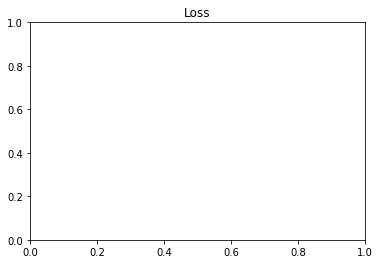

In [10]:
plt.title('Loss')
plt.plot(model.history['loss'], label='train')
plt.plot(model.history['val_loss'], label='test')
plt.legend()
plt.show();